<a href="https://colab.research.google.com/github/rakeshveerabhadrappa/BCG-VI/blob/main/Task3BCGGamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 771 kB/s 


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from category_encoders import OneHotEncoder

In [5]:
url_clientData = 'https://raw.githubusercontent.com/rakeshveerabhadrappa/BCG-VI/main/Data/client_data.csv'
clientDf = pd.read_csv(url_clientData)
url_priceData = 'https://raw.githubusercontent.com/rakeshveerabhadrappa/BCG-VI/main/Data/price_data.csv'
priceDataDf = pd.read_csv(url_priceData)


In [6]:
def convert2String(x):
  return f"{x} products" if x <6 else "over 6 products"
clientDf['nb_prod'] = clientDf['nb_prod_act'].apply(lambda x: convert2String(x))

def label_encoder(df):
    for i in cat_cols:
        le = LabelEncoder()# converts any string-based class information to numerical
        df[i] = le.fit_transform(df[i])
    return df

In [7]:
clientDf["date_activ"] = pd.to_datetime(clientDf["date_activ"], format='%Y-%m-%d')
clientDf["date_end"] = pd.to_datetime(clientDf["date_end"], format='%Y-%m-%d')
clientDf["date_modif_prod"] = pd.to_datetime(clientDf["date_modif_prod"], format='%Y-%m-%d')
clientDf["date_renewal"] = pd.to_datetime(clientDf["date_renewal"], format='%Y-%m-%d')
priceDataDf['price_date'] = pd.to_datetime(priceDataDf['price_date'], format='%Y-%m-%d')

In [8]:
mean_year = priceDataDf.groupby(['id']).mean().reset_index()
mean_6m = priceDataDf[priceDataDf['price_date'] > '2015-06-01'].groupby(['id']).mean().reset_index()
mean_3m = priceDataDf[priceDataDf['price_date'] > '2015-10-01'].groupby(['id']).mean().reset_index()

# Comnbine into single dataframe
mean_year = mean_year.rename(
    index=str, 
    columns={
        "price_off_peak_var": "mean_year_price_p1_var",
        "price_peak_var": "mean_year_price_p2_var",
        "price_mid_peak_var": "mean_year_price_p3_var",
        "price_off_peak_fix": "mean_year_price_p1_fix",
        "price_peak_fix": "mean_year_price_p2_fix",
        "price_mid_peak_fix": "mean_year_price_p3_fix"
    }
)

mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"]
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"]
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]

mean_6m = mean_6m.rename(
    index=str, 
    columns={
        "price_off_peak_var": "mean_6m_price_p1_var",
        "price_peak_var": "mean_6m_price_p2_var",
        "price_mid_peak_var": "mean_6m_price_p3_var",
        "price_off_peak_fix": "mean_6m_price_p1_fix",
        "price_peak_fix": "mean_6m_price_p2_fix",
        "price_mid_peak_fix": "mean_6m_price_p3_fix"
    }
)
mean_6m["mean_6m_price_p1"] = mean_6m["mean_6m_price_p1_var"] + mean_6m["mean_6m_price_p1_fix"]
mean_6m["mean_6m_price_p2"] = mean_6m["mean_6m_price_p2_var"] + mean_6m["mean_6m_price_p2_fix"]
mean_6m["mean_6m_price_p3"] = mean_6m["mean_6m_price_p3_var"] + mean_6m["mean_6m_price_p3_fix"]

mean_3m = mean_3m.rename(
    index=str, 
    columns={
        "price_off_peak_var": "mean_3m_price_p1_var",
        "price_peak_var": "mean_3m_price_p2_var",
        "price_mid_peak_var": "mean_3m_price_p3_var",
        "price_off_peak_fix": "mean_3m_price_p1_fix",
        "price_peak_fix": "mean_3m_price_p2_fix",
        "price_mid_peak_fix": "mean_3m_price_p3_fix"
    }
)
mean_3m["mean_3m_price_p1"] = mean_3m["mean_3m_price_p1_var"] + mean_3m["mean_3m_price_p1_fix"]
mean_3m["mean_3m_price_p2"] = mean_3m["mean_3m_price_p2_var"] + mean_3m["mean_3m_price_p2_fix"]
mean_3m["mean_3m_price_p3"] = mean_3m["mean_3m_price_p3_var"] + mean_3m["mean_3m_price_p3_fix"]


price_features = pd.merge(mean_year, mean_6m, on='id')
price_features = pd.merge(price_features, mean_3m, on='id')

In [9]:
price_analysis = pd.merge(price_features, clientDf[['id', 'churn']], on='id')

monthly_price_by_id = priceDataDf.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]

price_analysis = pd.merge(price_analysis, diff, on='id')

In [10]:
corrmat = price_analysis.drop(columns = ['id']).corr().abs()
upper_tri = corrmat.where(np.triu(np.ones(corrmat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

price_analysis_unCorrelatedFeatures = price_analysis.drop(columns = to_drop)

price_analysis_unCorrelatedFeatures =pd.merge(price_analysis_unCorrelatedFeatures, clientDf[['id', 'num_years_antig', 'nb_prod', 'has_gas']], on='id')

X = price_analysis_unCorrelatedFeatures.drop(columns = ['id','churn'])
y = price_analysis_unCorrelatedFeatures['churn']
num_cols = X.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_cols = X.select_dtypes(include = ['object']).columns.to_list()
cat_cols.append('num_years_antig')
X = label_encoder(X)
X['nb_prod'] = X['nb_prod'].apply(lambda x: convert2String(x))
encoder = OneHotEncoder(cols = cat_cols, use_cat_names = True)
X_afterOneHot =  encoder.fit_transform(X[X.columns])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: Undefine

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2630
           1       0.00      0.00      0.00       291

    accuracy                           0.90      2921
   macro avg       0.45      0.50      0.47      2921
weighted avg       0.81      0.90      0.85      2921

ROC AUC score: 0.597

-----------------------------------------------------

Cross-validation scores with 5 folds:

ROC AUC: 0.596


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

precision: 0.0
recall: 0.0
f1: 0.0


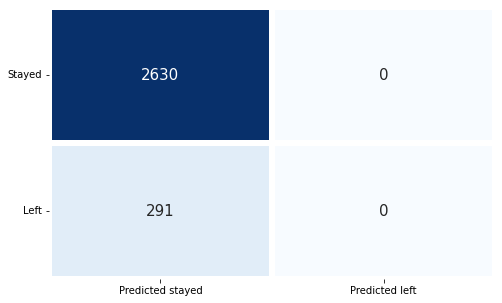

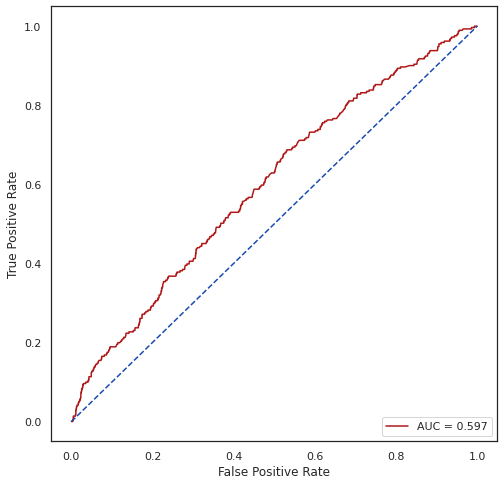

In [11]:
X = X_afterOneHot

results = pd.DataFrame(columns = ['LR', 'RF', 'LGBM', 'XGB'], index = range(4))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)




rf = RandomForestClassifier(random_state = 22, max_depth = 5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

# Metrics
results.iloc[0, 1] = round(precision_score(y_test, y_pred), 2)
results.iloc[1, 1] = round(recall_score(y_test, y_pred), 2)
results.iloc[2, 1] = round(f1_score(y_test, y_pred), 2)
results.iloc[3, 1] = round(roc_auc_score(y_test, y_prob), 3)
rf_cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {round(roc_auc_score(y_test, y_prob), 3)}')
print('')
print('-----------------------------------------------------')
print('')
print('Cross-validation scores with 5 folds:')
print('')
print(f"ROC AUC: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X, y, cv = 5, scoring = 'f1').mean(), 2)}")

# Visualize confusion matrix
plt.figure(figsize = (8, 5))
sns.heatmap(rf_cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
           yticklabels = ['Stayed', 'Left'], xticklabels = ['Predicted stayed', 'Predicted left'])
plt.yticks(rotation = 0)
plt.show()

# Roc curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

